In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
!pip install face_recognition
import face_recognition
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=8b6015a35b641b23a7e997a757333b96798ef37555f6ea3ced422a5d059afa71
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


RuntimeError: Error while calling cudaGetDevice(&the_device_id) in file /root/.cache/uv/sdists-v4/pypi/dlib/19.24.2/icsJnWNY82C6HzOHc39Tn/dlib-19.24.2.tar.gz/dlib/cuda/gpu_data.cpp:204. code: 35, reason: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
def validate_video(vid_path, train_transforms):
    transform = train_transforms
    count = 20
    video_path = vid_path
    frames = []
    a = int(100 / count)
    first_frame = np.random.randint(0, a)
    temp_video = video_path.split("/")[-1]
    for i, frame in enumerate(frame_extract(video_path)):
        frames.append(transform(frame))
        if len(frames) == count:
            break
    frames = torch.stack(frames)
    frames = frames[:count]
    return frames


# extract a from from video
def frame_extract(path):
    vidObj = cv2.VideoCapture(path)
    success = 1
    while success:
        success, image = vidObj.read()
        if success:
            yield image

In [ ]:
im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

In [ ]:
gbmd = {
    "file": [],
    "label": []
}
frame_count = []

video_files1 =  glob.glob('/content/drive/MyDrive/Celeb_fake_face_only/*.mp4')
for video_file in video_files1:
    cap = cv2.VideoCapture(video_file)
    if int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) < 100:
        video_files1.remove(video_file)
        continue
    frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
    gbmd["file"].append(video_file)
    gbmd["label"].append("FAKE")
print("Total no of video: ", len(frame_count))

print(gbmd["file"][432], gbmd["label"][432])

Total no of video:  596
/content/drive/MyDrive/Celeb_fake_face_only/id38_id32_0005.mp4 FAKE


In [ ]:
print(gbmd["file"][432], gbmd["label"][432])

/content/drive/MyDrive/Celeb_fake_face_only/id38_id32_0005.mp4 FAKE


In [ ]:
video_files2 = glob.glob('/content/drive/My Drive/Celeb_real_face_only/*.mp4')

for video_file in video_files2:
    cap = cv2.VideoCapture(video_file)
    if int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) < 100:
        video_files2.remove(video_file)
        continue
    frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
    gbmd["file"].append(video_file)
    gbmd["label"].append("REAL")

# print("frames are ", frame_count)
print("Total no of video: ", len(frame_count))

Total no of video:  1184


In [ ]:
print(gbmd["file"][908], gbmd["label"][908])

/content/drive/My Drive/Celeb_real_face_only/id20_0008.mp4 REAL


In [ ]:
# plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    b, g, r = cv2.split(image)
    image = cv2.merge((r, g, b))
    image = image * [0.22803, 0.22145, 0.216989] + [0.43216, 0.394666, 0.37645]
    image = image * 255.0
    plt.imshow(image.astype(int))
    plt.show()


def number_of_real_and_fake_videos(data_list):
    header_list = ["file", "label"]
    lab = pd.read_csv("/content/drive/My Drive/Gobal_metadata.csv", names=header_list)
    fake = 0
    real = 0
    if len(lab) > 0:
        for i in data_list:
            temp_video = i.split("/")[-1]
            if labels.loc[labels["file"] == temp_video].empty:
                print("No video with file name " + temp_video + " found.")
            else:
                label = lab.iloc[
                    (labels.loc[labels["file"] == temp_video].index.values[0]), 1
                ]
                if label == "FAKE":
                    fake += 1
                if label == "REAL":
                    real += 1
    # print(real)
    # print(fake)
    return real, fake

In [ ]:
# print(gbmd)
header_list = ["file","label"]
df = pd.DataFrame(gbmd).sample(frac=1)
# df = df.sample(frac=1)
# print(df)
df.to_csv('/content/drive/My Drive/Gobal_metadata.csv', header=False, index=False)
labels = pd.read_csv('/content/drive/My Drive/Gobal_metadata.csv',names=header_list)
# print(labels)
video_files = labels["file"]
# labels = labels["label"][1:]
# print(video_files[0])

In [ ]:
from sklearn.model_selection import train_test_split

# random.shuffle(gbmd)
# ---------------------------------------
total_files = len(video_files)
# print(total_files)
train_ratio = 0.7
test_ratio = 0.1

# Calculate the sizes of train, test, and validation sets
train_size = int(train_ratio * total_files)
test_size = int(test_ratio * total_files)
valid_size = total_files - train_size - test_size

# Split the video files into train, test, and validation sets
train_videos = video_files[:train_size]
test_videos = video_files[train_size:train_size+test_size]
valid_videos = video_files[train_size+test_size:]

# Print the sizes of the train, test, and validation sets
print("Train set size:", len(train_videos))
print("Validation set size:", len(valid_videos))
print("Test set size:", len(test_videos))

Train set size: 828
Validation set size: 238
Test set size: 118


In [ ]:
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('/content/drive/My Drive/Gobal_metadata.csv',names=header_list)
  fake = 0
  real = 0
  # print(data_list)
  if len(lab) > 0:
    for i in data_list:
      temp_video = i#.split('/')[-1]
      if labels.loc[labels["file"] == temp_video].empty:
        print("No video with file name " + temp_video + " found.")
      else:
        label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          fake+=1
        if(label == 'REAL'):
          real+=1
  # print(real)
  # print(fake)
  return real, fake

In [ ]:
trainCount = number_of_real_and_fake_videos(train_videos)
validCount = number_of_real_and_fake_videos(valid_videos)
testCount = number_of_real_and_fake_videos(test_videos)
print("TRAIN: ", "Real:",trainCount[0]," Fake:",trainCount[1])
print("VALID: ", "Real:",validCount[0]," Fake:",validCount[1])
print("TEST: ", "Real:",testCount[0]," Fake:",testCount[1])

TRAIN:  Real: 409  Fake: 419
VALID:  Real: 114  Fake: 124
TEST:  Real: 65  Fake: 53


In [ ]:
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

valid_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

In [ ]:
class video_dataset(Dataset):
    def __init__(self, video_names, labels, sequence_length=60, transform=None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        # print(self.video_names)
        video_path = self.video_names[idx]
        # print(video_path)
        frames = list(self.frame_extract(video_path))
        a = int(100 / self.count)
        first_frame = np.random.randint(0, a)
        temp_video = video_path#.split("/")[-1]
        # print(temp_video)
        if len(labels) == 0:
            print("No labels found.")
            return frames, None
        label = self.labels.iloc[
            (labels.loc[labels["file"] == temp_video].index.values[0]), 1
        ]
        if label == "FAKE":
            label = 0
        if label == "REAL":
            label = 1
        for i, frame in enumerate(frames):
            frames[i] = self.transform(frame)
            if len(frames) == self.count:
                break
        frames = torch.stack(frames)
        frames = frames[: self.count]
        # print("length:" , len(frames), "label",label)
        return frames, label

    def frame_extract(self, path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

In [ ]:
train_data = video_dataset(train_videos.reset_index(drop=True),labels,sequence_length = 10,transform = train_transforms)
val_data = video_dataset(valid_videos.reset_index(drop=True),labels,sequence_length = 10,transform = train_transforms)
test_data = video_dataset(test_videos.reset_index(drop=True),labels,sequence_length = 10,transform = train_transforms)

train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
test_loader = DataLoader(test_data,batch_size = 4,shuffle = True,num_workers = 4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
for batch_idx, (data, target) in enumerate(valid_loader):
       if torch.isnan(data).any() or torch.isinf(data).any():
           print(f"Found NaN or Inf in data at batch index {batch_idx}")

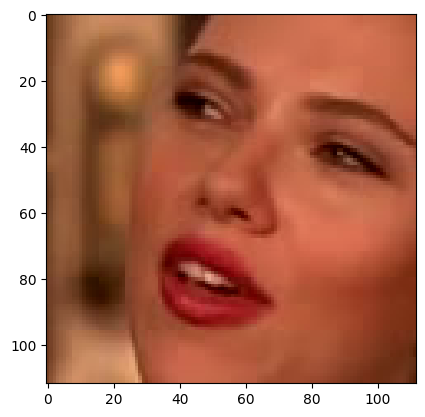

In [ ]:
image,label = train_data[0]
# print(image, label)
im_plot(image[0,:,:,:])

In [ ]:
num_inputs = len(valid_loader.dataset)
print("Number of inputs:", num_inputs)

num_batches = len(valid_loader)
print("Number of batches:", num_batches)

Number of inputs: 238
Number of batches: 60


In [ ]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [ ]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 114MB/s]


In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
!pip install -Uqq ipdb
import ipdb
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        # print("asidh", outputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Clip gradients
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/content/checkpoint.pt')
    return losses.avg,accuracies.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.5 MB/s eta 0:00:00


In [ ]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [ ]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            # ipdb.set_trace()
            abc,outputs = model(inputs)
            # print("abc", abc, "\nOutputs", outputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1)
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Epoch 1/20] [Batch 206 / 207] [Loss: 0.541522, Acc: 50.24%][0.5415221658953722]
Testing
[Batch 206 / 207]  [Loss: 0.341381, Acc: 49.40%]
Accuracy 49.39613526570049
[0.34138124497328404]
[Epoch 2/20] [Batch 206 / 207] [Loss: 0.410226, Acc: 49.76%][0.5415221658953722, 0.4102264988609558]
Testing
[Batch 206 / 207]  [Loss: 0.257204, Acc: 61.23%]
Accuracy 61.231884057971016
[0.34138124497328404, 0.2572035531418911]
[Epoch 3/20] [Batch 206 / 207] [Loss: 0.387859, Acc: 71.26%][0.5415221658953722, 0.4102264988609558, 0.38785911416229996]
Testing
[Batch 206 / 207]  [Loss: 0.158871, Acc: 91.06%]
Accuracy 91.06280193236715
[0.34138124497328404, 0.2572035531418911, 0.15887086570334896]
[Epoch 4/20] [Batch 206 / 207] [Loss: 0.341799, Acc: 82.25%][0.5415221658953722, 0.4102264988609558, 0.38785911416229996, 0.34179878236662936]
Testing
[Batch 206 / 207]  [Loss: 0.167701, Acc: 94.44%]
Accuracy 94.44444444444444
[0.34138124497328404, 0.2572035531418911, 0.15887086570334896, 0.16770077239781628]
[Epoc

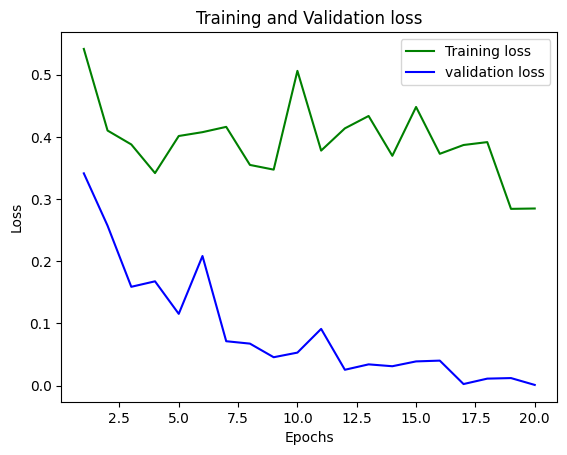

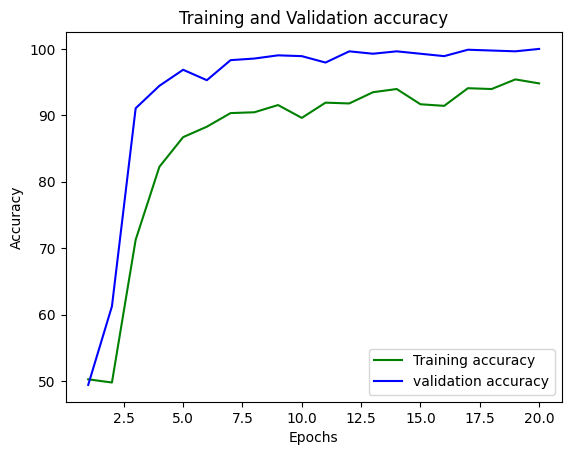

[[419   0]
 [  0 409]]
True positive =  419
False positive =  0
False negative =  0
True negative =  409




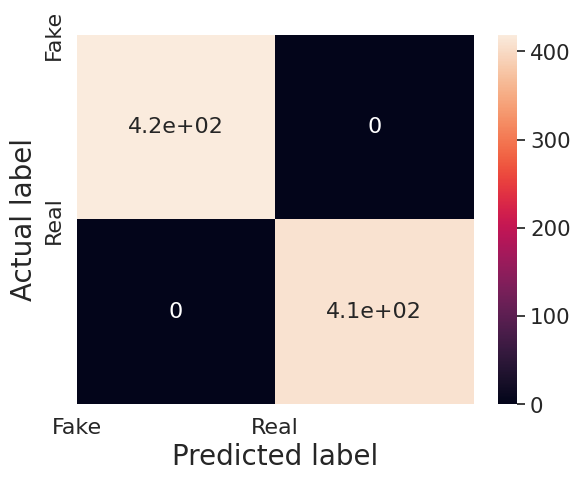

Calculated Accuracy 100.0


In [ ]:
from sklearn.metrics import confusion_matrix

#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-7)

class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
# criterion = nn.CrossEntropyLoss().cuda()
# criterion = nn.BCELoss().cuda()

train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1, num_epochs + 1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    print(train_loss_avg)
    true,pred,tl,t_acc = test(epoch,model,train_loader,criterion)
    test_loss_avg.append(tl)
    print(test_loss_avg)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)

Testing


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Batch 29 / 30]  [Loss: 0.779314, Acc: 80.51%]
Accuracy 80.50847457627118
[[46  7]
 [16 49]]
True positive =  46
False positive =  7
False negative =  16
True negative =  49




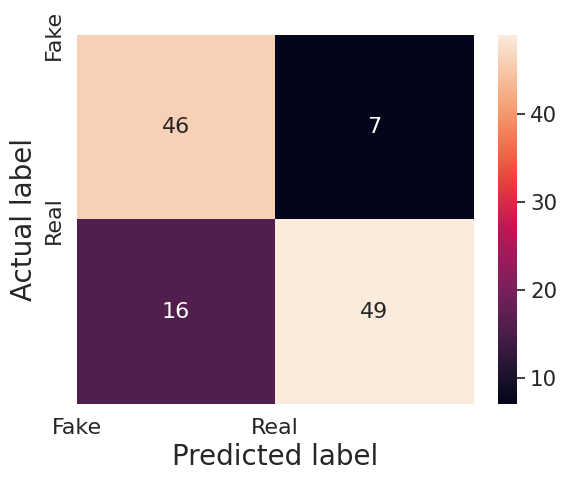

Calculated Accuracy 80.50847457627118


In [ ]:
Real_test_loss_avg = []
Real_test_accuracy = []
RealTesttrue,RealTestpred,RealTesttl,RealTestt_acc = test(1,model,test_loader,criterion)
Real_test_loss_avg.append(RealTesttl)
Real_test_accuracy.append(RealTestt_acc)
# plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
# plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(RealTesttrue,RealTestpred))
print_confusion_matrix(RealTesttrue,RealTestpred)


In [ ]:
torch.save(model.state_dict(), '/content/saved_model.pth')


In [ ]:
# -------
path_to_model = "/content/drive/MyDrive/FF_88_acc_seqLen_20_Confusion_matrix.pth"
